In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


## Loading

In [2]:
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src.modules.data_spliting import split_train_test
from src.modules.data_preprocessing import load_data
import random
from src.modules.data_partition import data_partition
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import add_missing
from src.fed_imp.sub_modules.client.client_factory import ClientsFactory
from src.fed_imp.sub_modules.strategy.strategy_imp import StrategyImputation
from src.fed_imp.sub_modules.server.load_server import load_server
from src.fed_imp.sub_modules.client.simple_client import SimpleClient

In [3]:
import missingno as msno
def visualize_ms(clients_ms_datas:list, sort_patterns: bool = False):
    n_cols = 5
    n_clients = len(clients_ms_datas)
    n_rows = (n_clients + 4)//n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3), squeeze=False)
    for i in range(n_clients):
        ax = axes[i//n_cols, i%n_cols]
        d = pd.DataFrame(clients_ms_datas[i])
        d = d.sort_values(by=d.columns[-1])
        if sort_patterns:
            msno.matrix(d, ax=ax, sparkline=False, sort='ascending')
        else:
            msno.matrix(d, ax=ax, sparkline=False)
        ax.set_title('Client {}'.format(i))
    plt.tight_layout()

def correlation(original_data, centralized_data):
    from dython.nominal import correlation_ratio
    original_df = pd.DataFrame(original_data)
    target_col = original_df.columns[-1]
    correlation_ret = original_df.corrwith(original_df[target_col], method=correlation_ratio).sort_values(ascending=False)
    print(correlation_ret)

    centralized_df = pd.DataFrame(centralized_data)
    target_col = centralized_df.columns[-1]
    correlation_ret = centralized_df.corrwith(original_df[target_col], method=correlation_ratio).sort_values(ascending=False)
    print(correlation_ret)

def sklearn_evaluation(ret):
    from sklearn.neural_network import MLPClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import metrics

    original_data = ret['data']['origin_data'].reshape(-1, 23)
    print(original_data.shape)
    centralized_data = ret['data']['imputed_data'].reshape(-1, 23)
    print(centralized_data.shape)
    test_data = ret['data']['test_data']
    print(test_data.shape)

    X_train = centralized_data[:, :-1]
    y_train = centralized_data[:, -1]
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    clf = MLPClassifier([32, 32], batch_size = 128, random_state=21, alpha = 0.001, max_iter = 500).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy imputed centralized MLP:", metrics.accuracy_score(y_test, y_pred))

    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy imputed centralized LR:", metrics.accuracy_score(y_test, y_pred))

    clf = RandomForestClassifier(n_estimators = 200, random_state=0).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy imputed centralized RF:", metrics.accuracy_score(y_test, y_pred))

    X_train = original_data[:, :-1]
    y_train = original_data[:, -1]
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    clf = MLPClassifier([32, 32], batch_size = 128, random_state=21, alpha = 0.001, max_iter=500).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy all clients complete data centralized MLP:", metrics.accuracy_score(y_test, y_pred))

    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy all clients complete data centralized MLP:", metrics.accuracy_score(y_test, y_pred))

    clf = RandomForestClassifier(n_estimators = 200, random_state=0).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy all clients complete data centralized MLP:", metrics.accuracy_score(y_test, y_pred))

In [184]:
experiment_config_template = {
  "num_clients": 20,
  "data": {
    "dataset_name": "ijcnn_balanced",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=0.01",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mary_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": False
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 40,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 0.8,
      "beta": 0.15
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    "scale_factor": 4
  }
}

## Simulation

## MARY - Naive Avgerage

### simulate missing

In [237]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'ijcnn_balanced'
config['num_clients'] = 20
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_lr@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.01'

In [205]:
configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}


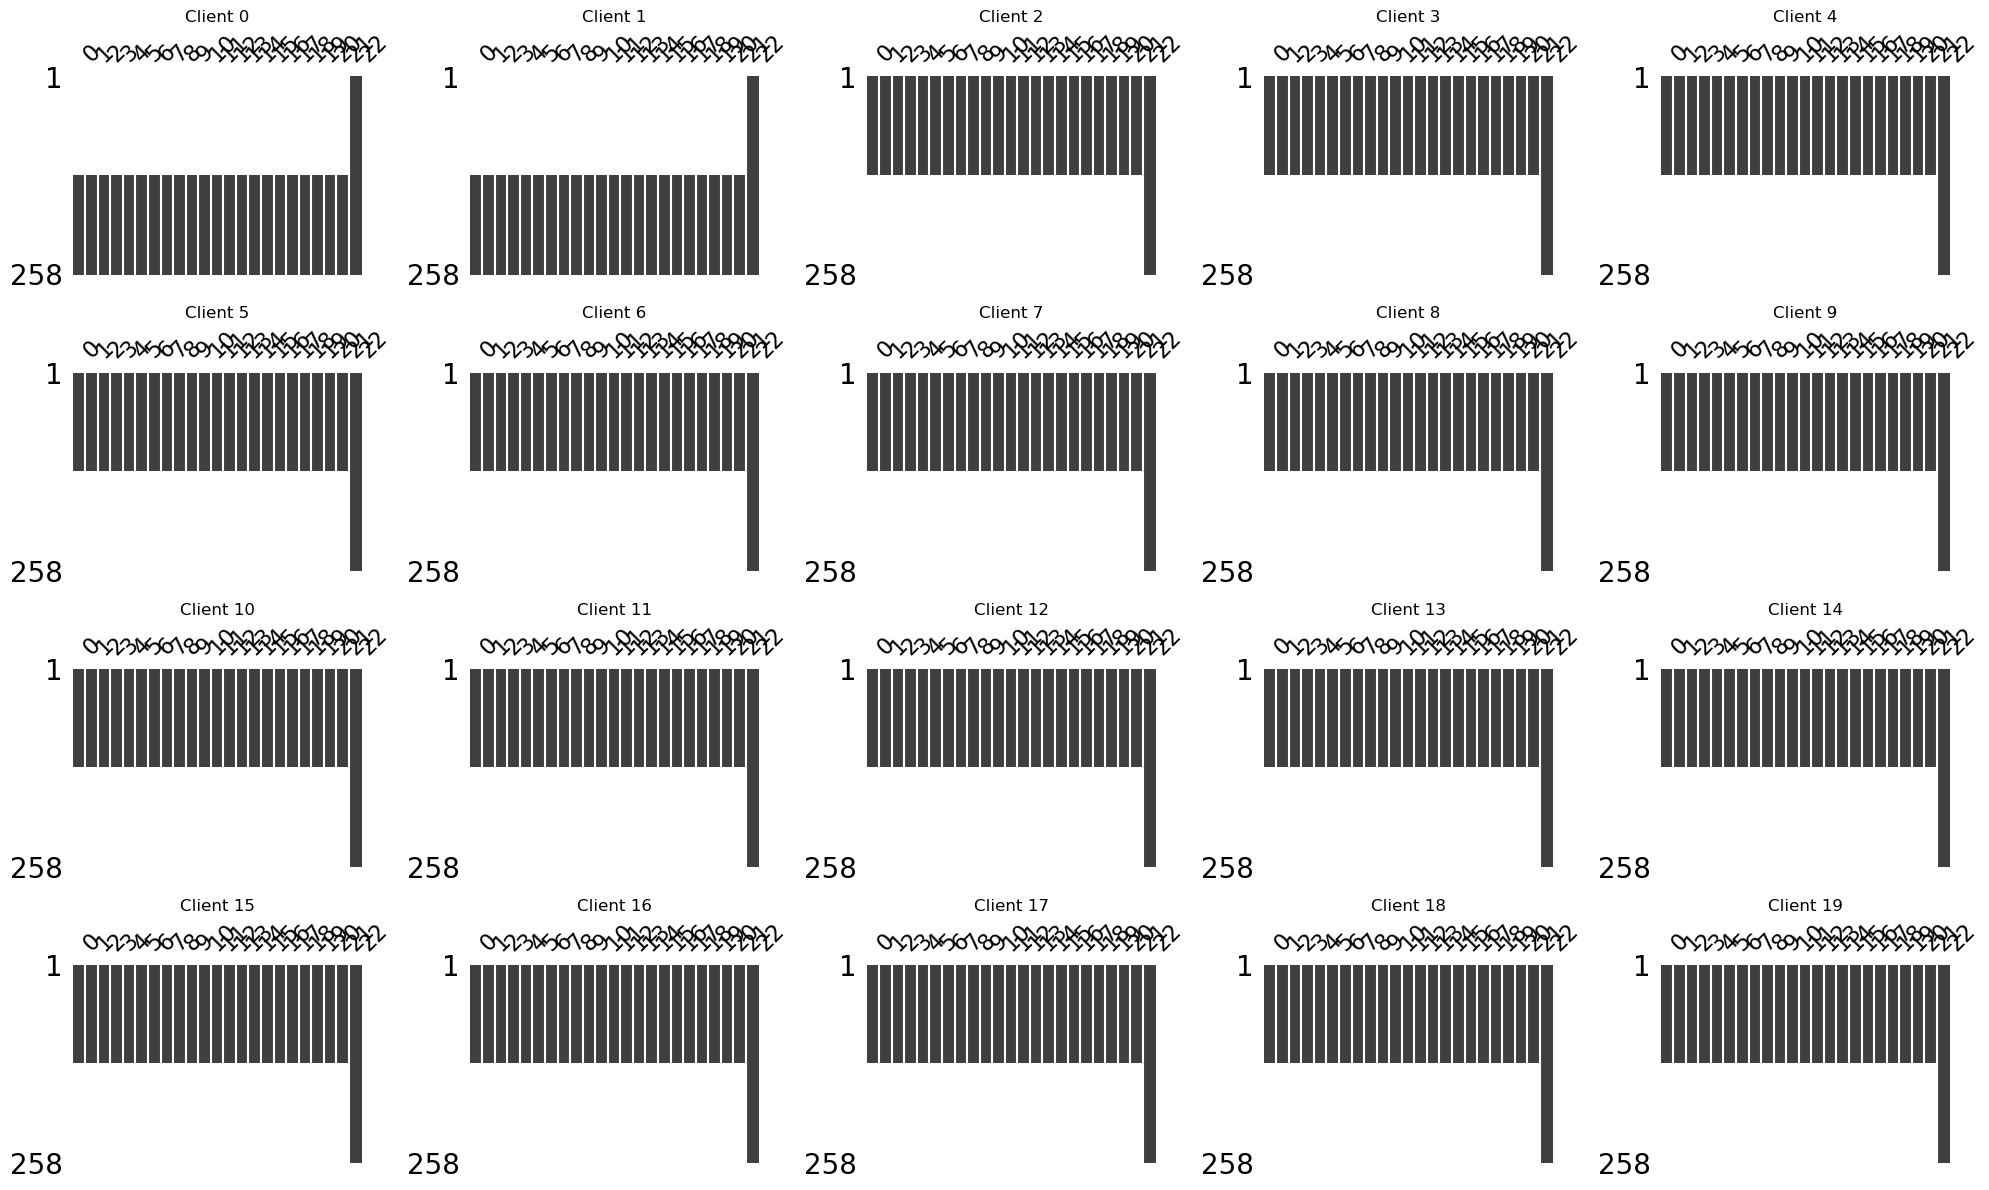

In [206]:
visualize_ms(data_ms_clients)

### Federated Imputation

In [83]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret = server.run()

2023-07-18 20:15:52.735 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 50, test_accu: 0.5000, test_f1: 0.3334, val_loss: 0.6573, val_accu: 0.9000, val_f1: 0.9000
2023-07-18 20:16:18.936 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 100, test_accu: 0.5000, test_f1: 0.3334, val_loss: 0.6300, val_accu: 0.9000, val_f1: 0.9000
2023-07-18 20:16:45.364 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 150, test_accu: 0.5000, test_f1: 0.3334, val_loss: 0.6275, val_accu: 0.9000, val_f1: 0.9000
2023-07-18 20:17:11.398 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 200, test_accu: 0.5000, test_f1: 0.3334, val_loss: 0.6147, val_accu: 0.9000, val_f1: 0.9000
2023-07-18 20:17:11.399 | INFO     | src.fed_imp.sub_modules.server.base_server:run:141 - model1 test acc: 0.502488 (0.000), test f1: 0.488665 (0.000)
2023-07-18 20:17:11.400 | INFO     | src.fed_imp.sub_modul

In [198]:
original_data = ret['data']['origin_data'].reshape(-1, 23)
print(original_data.shape)
centralized_data = ret['data']['imputed_data'].reshape(-1, 23)
print(centralized_data.shape)
test_data = ret['data']['test_data']
print(test_data.shape)
print(ret['imp_result'])

(5160, 23)
(5160, 23)
(11051, 23)
{'imp@rmse': 0.22082776352819666, 'imp@ws': 1.3216495839390234, 'imp@sliced_ws': 0.10704967619398463}


### Correlation

In [144]:
correlation(original_data, centralized_data)

22    1.000000
17    0.514779
16    0.292419
19    0.179807
18    0.155243
20    0.067698
21    0.054012
15    0.043808
14    0.042823
12    0.030853
13    0.027767
11    0.023026
4     0.021014
6     0.018914
5     0.017251
8     0.016710
3     0.015667
1     0.012346
10    0.008624
2     0.005789
7     0.002602
9     0.001334
0     0.000639
dtype: float64
22    1.000000
17    0.142916
16    0.070417
18    0.060328
11    0.050566
19    0.046449
0     0.032078
7     0.026157
13    0.025601
1     0.024936
2     0.022508
20    0.016388
12    0.013293
8     0.011843
3     0.011338
10    0.009711
21    0.007218
5     0.007117
15    0.005028
6     0.003802
4     0.002757
14    0.001223
9     0.000480
dtype: float64


### Centralized Evaluation

In [129]:
sklearn_evaluation(ret)

(5160, 23)
(5160, 23)
(11051, 23)
Accuracy imputed centralized MLP: 0.7766717944077459
Accuracy imputed centralized LR: 0.7434621301239707
Accuracy imputed centralized RF: 0.8011944620396344
Accuracy all clients complete data centralized MLP: 0.9577413808705094
Accuracy all clients complete data centralized MLP: 0.8653515518957561
Accuracy all clients complete data centralized MLP: 0.9477875305402226


### Evaluation FedAvg Our Implementation

In [134]:
server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 128,
            "learning_rate": 0.001,
            "weight_decay": 0.001,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [137]:
clients = {}
data_imp = ret['data']['imputed_data']
missing_mask = ret['data']['missing_mask']
data_true = ret['data']['origin_data']
n_clients = ret['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data
    )

pred_ret = server.prediction()

2023-07-18 21:03:08.602 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.5000, test_f1: 0.3334, val_loss: 0.4866, val_accu: 0.9000, val_f1: 0.9000


KeyboardInterrupt: 

## MARY - Use complementary Models

In [238]:
config = experiment_config_template.copy()
config['data']['dataset_name'] = 'ijcnn_balanced'
config['num_clients'] = 20
config['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config['missing_simulate']['mf_strategy'] = 'all'
config['missing_simulate']['mm_strategy'] = 'mary_lr@sp=extreme'
config['data_partition']['strategy'] = 'sample@p=0.01'

configuration = config
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}
['mary_left' 'mary_left' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right'
 'mary_right' 'mary_right' 'mary_right' 'mary_right' 'mary_right']


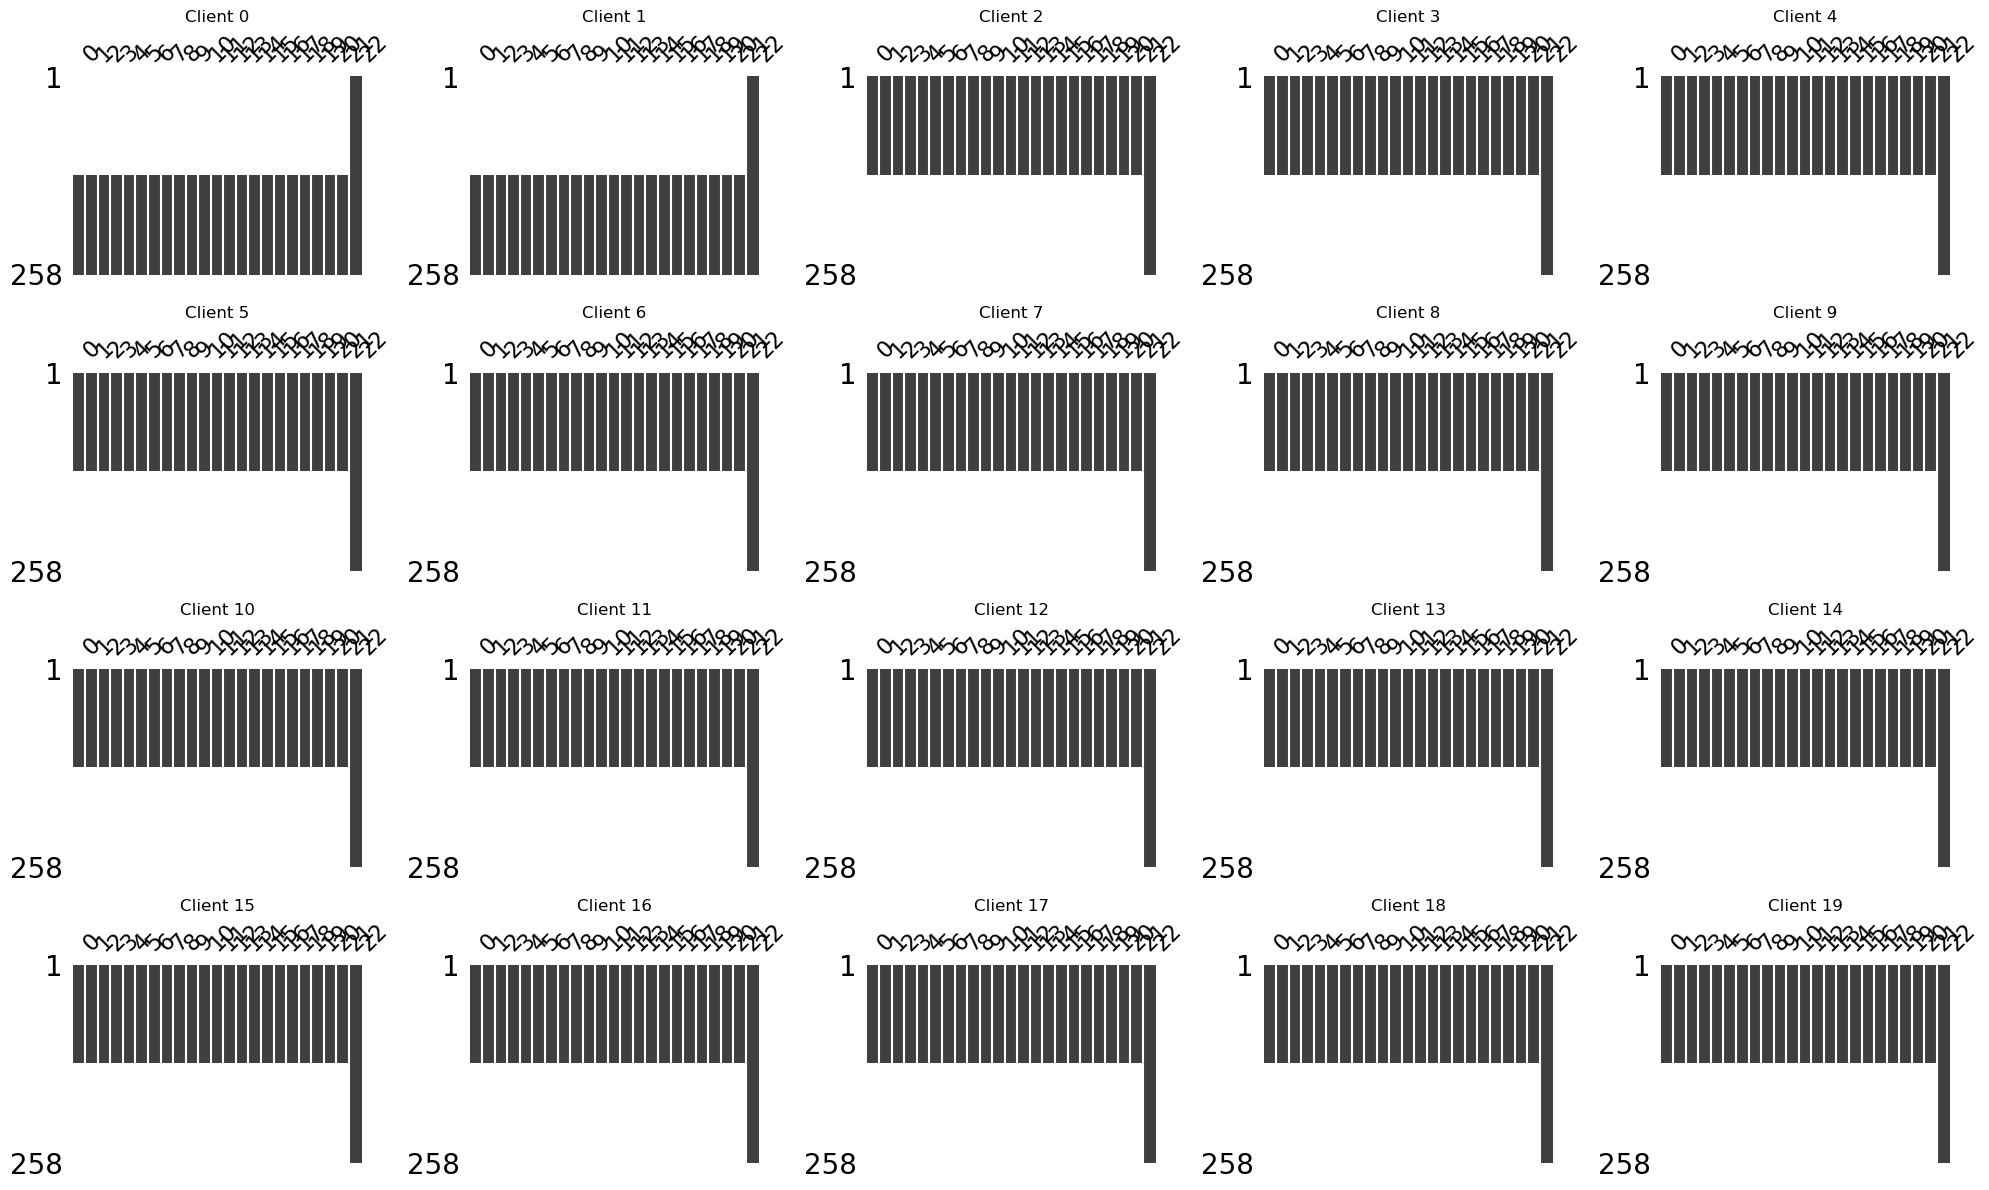

In [239]:
visualize_ms(data_ms_clients)

In [240]:
configuration['agg_strategy_imp']['strategy'] = 'testavg'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret3 = server.run()

testavg
[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[-0.82782924 -0.82469221 -0.8299143  -0.83864867 -0.82527235 -0.83940965
 -0.83052863 -0.82023642 -0.82812667  0.01332788 -0.01194848 -0.08204635
 -0.04416263  0.01788797  0.11561869 -0.07819609 -0.07280367 -0.06400431
 -0.10936872 -0.03989598  0.08915541  0.96570132]
[-0.9060766  -0.9023819  -0.90809895 -0.91354936 -0.90368022 -0.91197118
 -0.90937257 -0.9021223  -0.90643155  0.00292916  0.00162942 -0.05014014
 -0.06025643  0.01461137  0.06994511 -0.05713277 -0.01284788 -0.00379983
 -0.00367193  0.01400109  0.07449482  0.92279047]
cluster1 - 0
cluster1 - 1
cluster2 - 2
cluster2 - 3
cluster2 - 4
cluster2 - 5
cluster2 - 6
cluster2 - 7
cluster2 - 8
cluster2 - 9
cluster2 - 10
cluster2 - 11
cluster2 - 12
cluster2 - 13
cluster2 - 14
cluster2 - 15
cluster2 - 16
cluster2 - 17
cluster2 - 18
cluster2 - 19
[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[-9.13163156e-01 -9.33157984e-01 -9.2543

KeyboardInterrupt: 

In [210]:
original_data3 = ret3['data']['origin_data'].reshape(-1, 23)
print(original_data.shape)
centralized_data3 = ret3['data']['imputed_data'].reshape(-1, 23)
print(centralized_data.shape)
test_data3 = ret3['data']['test_data']
print(test_data.shape)
ret3['imp_result']

(5160, 23)
(5160, 23)
(11051, 23)


{'imp@rmse': 0.22098646694781393,
 'imp@ws': 1.3112988747834704,
 'imp@sliced_ws': 0.10619104187322245}

In [211]:
correlation(original_data3, centralized_data3)

22    1.000000
17    0.514779
16    0.292419
19    0.179807
18    0.155243
20    0.067698
21    0.054012
15    0.043808
14    0.042823
12    0.030853
13    0.027767
11    0.023026
4     0.021014
6     0.018914
5     0.017251
8     0.016710
3     0.015667
1     0.012346
10    0.008624
2     0.005789
7     0.002602
9     0.001334
0     0.000639
dtype: float64
22    1.000000
17    0.649921
16    0.349266
19    0.291514
18    0.217317
0     0.132751
1     0.106678
2     0.105485
13    0.100958
20    0.085861
7     0.071637
3     0.059524
12    0.044589
4     0.036583
9     0.016757
6     0.016738
21    0.013833
5     0.013208
8     0.011068
14    0.007431
11    0.007189
10    0.003983
15    0.002235
dtype: float64


In [212]:
sklearn_evaluation(ret3)

(5160, 23)
(5160, 23)
(11051, 23)
Accuracy imputed centralized MLP: 0.769613609628088
Accuracy imputed centralized LR: 0.8013754411365487
Accuracy imputed centralized RF: 0.8036376798479775
Accuracy all clients complete data centralized MLP: 0.9577413808705094
Accuracy all clients complete data centralized MLP: 0.8653515518957561
Accuracy all clients complete data centralized MLP: 0.9477875305402226


In [214]:
clients = {}
data_imp = ret3['data']['imputed_data']
missing_mask = ret3['data']['missing_mask']
data_true = ret3['data']['origin_data']
n_clients = ret3['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp[client_id],
        missing_mask=missing_mask[client_id],
        data_true=data_true[client_id],
        data_test=test_data3
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data3
    )

pred_ret = server.prediction()

2023-07-18 22:27:02.237 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.5000, test_f1: 0.3334, val_loss: 0.3831, val_accu: 0.9000, val_f1: 0.9000
2023-07-18 22:27:39.963 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.5000, test_f1: 0.3334, val_loss: 0.3913, val_accu: 0.9000, val_f1: 0.9000
2023-07-18 22:28:18.268 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.5000, test_f1: 0.3334, val_loss: 0.3863, val_accu: 0.9000, val_f1: 0.9000
2023-07-18 22:28:55.684 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.5000, test_f1: 0.3334, val_loss: 0.3805, val_accu: 0.9000, val_f1: 0.9000
2023-07-18 22:29:33.274 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.5000, test_f1: 0.333

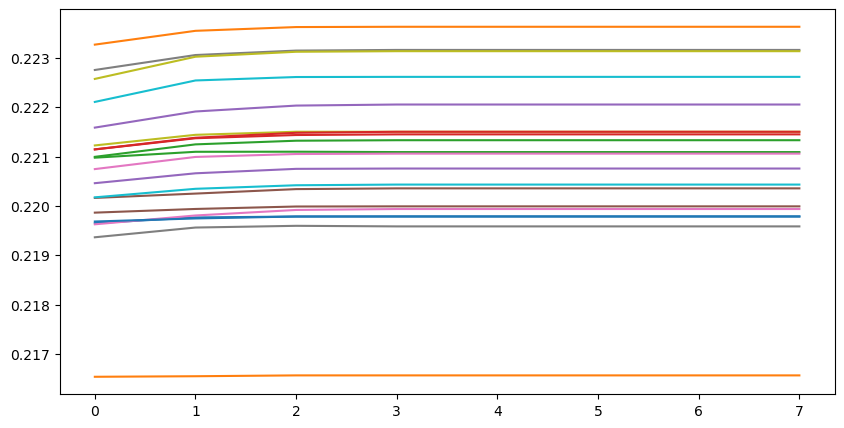

In [223]:
x = list(range(len(ret3['client_imp_history'])))
client_ids = list(ret3['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret3['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

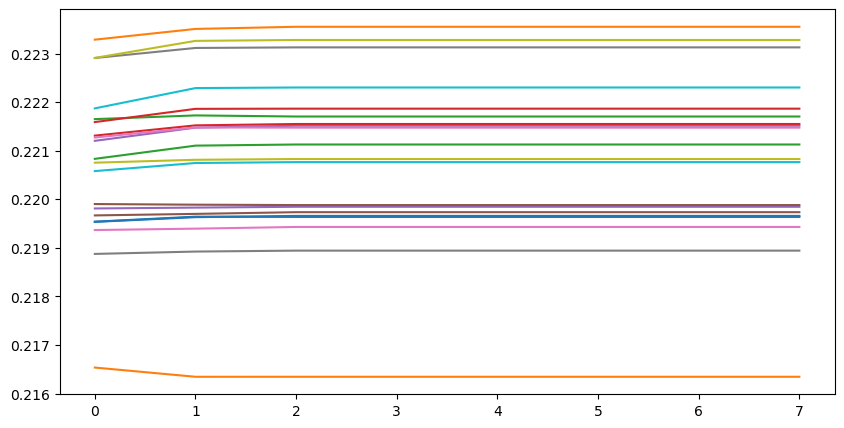

In [224]:
x = list(range(len(ret['client_imp_history'])))
client_ids = list(ret['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

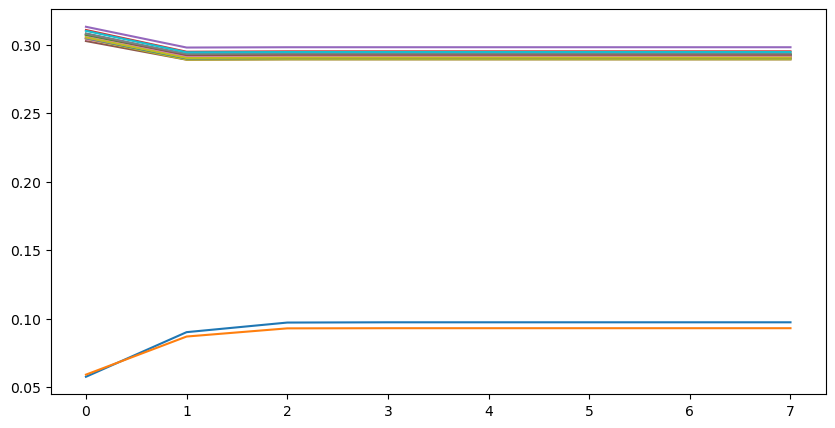

In [225]:
x = list(range(len(ret2['client_imp_history'])))
client_ids = list(ret2['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret2['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

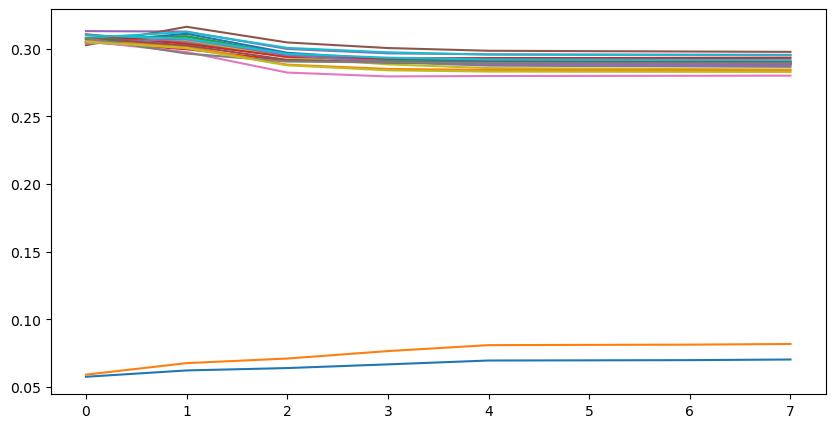

In [226]:
x = list(range(len(ret4['client_imp_history'])))
client_ids = list(ret4['client_imp_history'][0][2]['metrics'].keys())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for client_id in client_ids:
    y = [ret4['client_imp_history'][i][2]['metrics'][client_id]['imp@rmse'] for i in x]
    ax.plot(x, y, label=client_id)
plt.show()

## MNAR

### Simulate Missing

In [242]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mnar_lr@sp=extreme'
config2['data_partition']['strategy'] = 'sample@p=0.01'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

In [243]:
configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '0.01'}
['mnar_quantile_left' 'mnar_quantile_left' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right' 'mnar_quantile_right'
 'mnar_quantile_right' 'mnar_quantile_right']


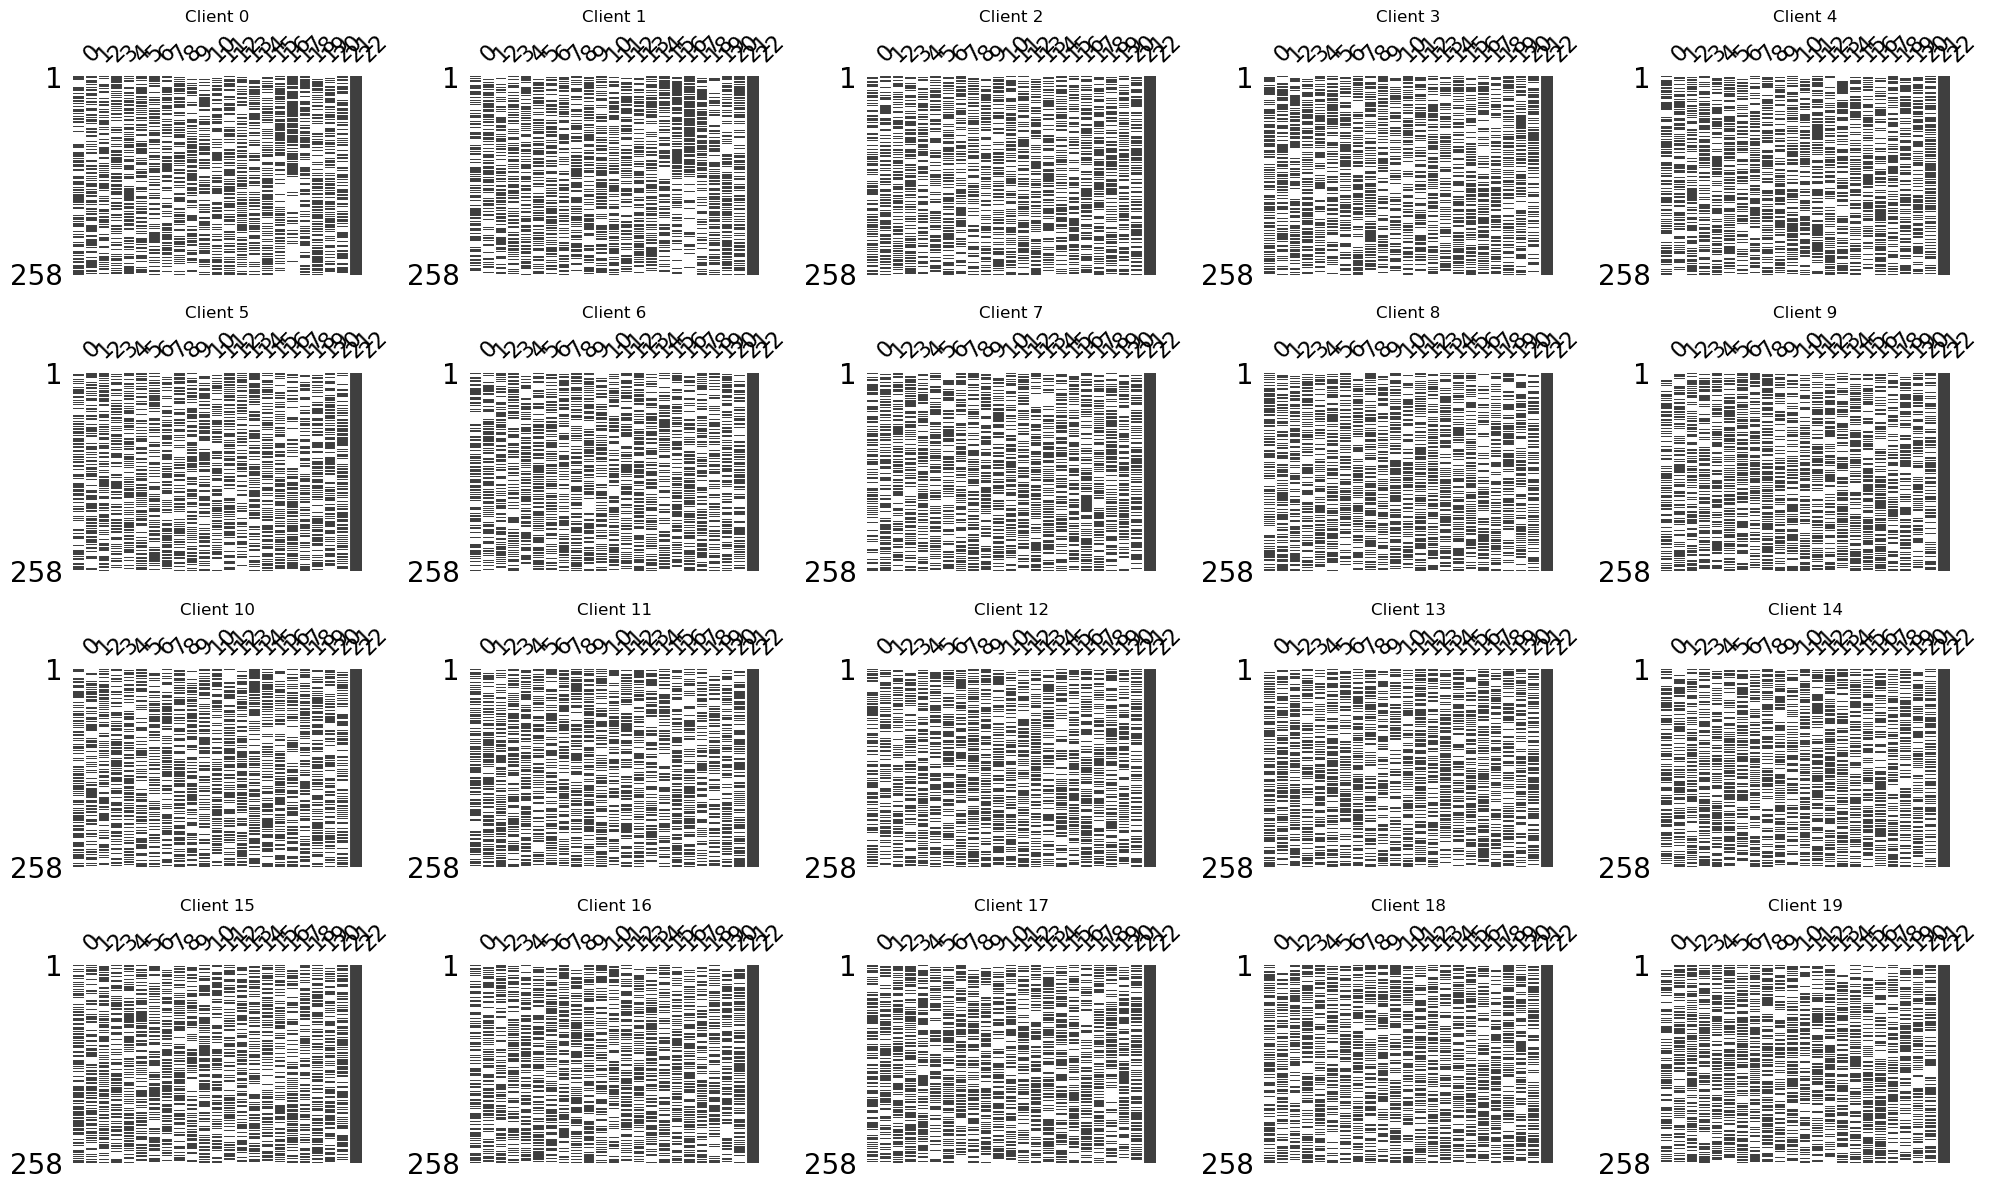

In [153]:
visualize_ms(data_ms_clients2)

### Federated Imputation

In [154]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = True
configuration['save_state'] = True
configuration['track'] = True

In [155]:
# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret2 = server.run()

2023-07-18 21:18:46.314 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 50, test_accu: 0.6998, test_f1: 0.6996, val_loss: 0.6177, val_accu: 0.6519, val_f1: 0.6519
2023-07-18 21:19:13.370 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 100, test_accu: 0.7248, test_f1: 0.7212, val_loss: 0.5759, val_accu: 0.6981, val_f1: 0.6979
2023-07-18 21:19:39.260 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 150, test_accu: 0.7138, test_f1: 0.7057, val_loss: 0.5639, val_accu: 0.7038, val_f1: 0.7032
2023-07-18 21:20:05.668 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:154 - Round: 200, test_accu: 0.7148, test_f1: 0.7071, val_loss: 0.5580, val_accu: 0.6962, val_f1: 0.6954
2023-07-18 21:20:05.669 | INFO     | src.fed_imp.sub_modules.server.base_server:run:141 - model1 test acc: 0.766356 (0.000), test f1: 0.765726 (0.000)
2023-07-18 21:20:05.670 | INFO     | src.fed_imp.sub_modul

In [167]:
original_data2 = ret2['data']['origin_data'].reshape(-1, 23)
print(original_data2.shape)
centralized_data2 = ret2['data']['imputed_data'].reshape(-1, 23)
print(centralized_data2.shape)
test_data2 = ret2['data']['test_data']
print(test_data2.shape)
print(ret2['imp_result'])

(5160, 23)
(5160, 23)
(11051, 23)
{'imp@rmse': 0.2725227567386814, 'imp@ws': 1.344050429730168, 'imp@sliced_ws': 0.1519631887491971}


### Centralized Evaluation

In [162]:
sklearn_evaluation(ret2)

(5160, 23)
(5160, 23)
(11051, 23)
Accuracy imputed centralized MLP: 0.7996561397158628
Accuracy imputed centralized LR: 0.7693421409827165
Accuracy imputed centralized RF: 0.9059813591530178
Accuracy all clients complete data centralized MLP: 0.9577413808705094
Accuracy all clients complete data centralized MLP: 0.8653515518957561
Accuracy all clients complete data centralized MLP: 0.9477875305402226


In [170]:
clients = {}
data_imp2 = ret2['data']['imputed_data']
missing_mask2 = ret2['data']['missing_mask']
data_true2 = ret2['data']['origin_data']
n_clients = ret2['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp2[client_id],
        missing_mask=missing_mask2[client_id],
        data_true=data_true2[client_id],
        data_test=test_data2
    )

pred_config = server_config_tmpl.copy()
server_name = 'central_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data2
    )

pred_ret2 = server.prediction()

2023-07-18 21:26:44.894 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5104, train_loss: 0.6928 val_accu: 0.5837 val_f1: 0.5588
2023-07-18 21:26:46.122 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 10, test_accu: 0.5425, train_loss: 0.6640 val_accu: 0.6067 val_f1: 0.6061
2023-07-18 21:26:47.282 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 20, test_accu: 0.6699, train_loss: 0.6288 val_accu: 0.6615 val_f1: 0.6592
2023-07-18 21:26:48.407 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 30, test_accu: 0.7387, train_loss: 0.5919 val_accu: 0.7144 val_f1: 0.7140
2023-07-18 21:26:49.580 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 40, test_accu: 0.7312, train_loss: 0.5909 val_accu: 0.7038 val_f1: 0.7011
2023-07-18 21:26:50.764 | INFO 

In [171]:
pred_ret2

{'accu_mean': 0.7963080264229482,
 'f1_mean': 0.7960566237458183,
 'accu_std': 0.0,
 'f1_std': 0.0}

### Federated Evaluation Our Implementation

In [172]:
clients = {}
data_imp2 = ret2['data']['imputed_data']
missing_mask2 = ret2['data']['missing_mask']
data_true2 = ret2['data']['origin_data']
n_clients = ret2['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp2[client_id],
        missing_mask=missing_mask2[client_id],
        data_true=data_true2[client_id],
        data_test=test_data2
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data2
    )

pred_ret2 = server.prediction()

2023-07-18 21:30:34.456 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.6464, test_f1: 0.6409, val_loss: 0.6403, val_accu: 0.6500, val_f1: 0.6472
2023-07-18 21:31:11.998 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.6963, test_f1: 0.6794, val_loss: 0.6070, val_accu: 0.7019, val_f1: 0.7013
2023-07-18 21:31:49.818 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.7137, test_f1: 0.7076, val_loss: 0.5939, val_accu: 0.7038, val_f1: 0.7033
2023-07-18 21:32:27.581 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.7296, test_f1: 0.7288, val_loss: 0.5837, val_accu: 0.7077, val_f1: 0.7076
2023-07-18 21:33:05.347 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.7437, test_f1: 0.743

## MNAR - Use complementary Models

In [248]:
configuration['agg_strategy_imp']['strategy'] = 'testavg'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret4 = server.run()

testavg


2023-07-18 23:13:22.270 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 208.84707290004008


In [249]:
original_data4 = ret4['data']['origin_data'].reshape(-1, 23)
print(original_data4.shape)
centralized_data4 = ret4['data']['imputed_data'].reshape(-1, 23)
print(centralized_data4.shape)
test_data4 = ret4['data']['test_data']
print(test_data4.shape)
ret4['imp_result']

(5160, 23)
(5160, 23)
(11051, 23)


{'imp@rmse': 0.2608438549664342,
 'imp@ws': 1.3546523496258889,
 'imp@sliced_ws': 0.07479604429657892}

In [250]:
correlation(original_data4, centralized_data4)
sklearn_evaluation(ret4)

22    1.000000
17    0.514779
16    0.292419
19    0.179807
18    0.155243
20    0.067698
21    0.054012
15    0.043808
14    0.042823
12    0.030853
13    0.027767
11    0.023026
4     0.021014
6     0.018914
5     0.017251
8     0.016710
3     0.015667
1     0.012346
10    0.008624
2     0.005789
7     0.002602
9     0.001334
0     0.000639
dtype: float64
22    1.000000
17    0.392094
16    0.177818
19    0.149519
6     0.128470
18    0.109890
11    0.097271
20    0.077515
4     0.062998
15    0.062566
5     0.052090
12    0.046956
21    0.044517
1     0.035751
8     0.029825
13    0.028515
7     0.026378
0     0.025644
3     0.023337
10    0.017762
14    0.015612
2     0.005246
9     0.000202
dtype: float64
(5160, 23)
(5160, 23)
(11051, 23)
Accuracy imputed centralized MLP: 0.8187494344403221
Accuracy imputed centralized LR: 0.8659849787349562
Accuracy imputed centralized RF: 0.8974753415980454
Accuracy all clients complete data centralized MLP: 0.9577413808705094
Accuracy all clien

In [251]:
clients = {}
data_imp2 = ret4['data']['imputed_data']
missing_mask2 = ret4['data']['missing_mask']
data_true2 = ret4['data']['origin_data']
n_clients = ret4['data']['origin_data'].shape[0]
for client_id in range(n_clients):
    clients[client_id] = SimpleClient(
        client_id=client_id,
        data_imp=data_imp2[client_id],
        missing_mask=missing_mask2[client_id],
        data_true=data_true2[client_id],
        data_test=test_data4
    )

pred_config = server_config_tmpl.copy()
server_name = 'fedavg_mlp_pytorch_pred'
server_pred_config = pred_config['server_pred_config']
server_pred_config['train_params']['pred_round'] = 1000
server_config = pred_config['server_config']
server = load_server(
        server_name, clients=clients, server_config=server_config, pred_config=server_pred_config,
        test_data=test_data4
    )

pred_ret2 = server.prediction()

2023-07-18 23:17:36.095 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 50, test_accu: 0.6606, test_f1: 0.6600, val_loss: 0.6128, val_accu: 0.6837, val_f1: 0.6805
2023-07-18 23:18:17.249 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 100, test_accu: 0.8357, test_f1: 0.8354, val_loss: 0.5484, val_accu: 0.7327, val_f1: 0.7306
2023-07-18 23:18:56.077 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 150, test_accu: 0.8286, test_f1: 0.8284, val_loss: 0.5394, val_accu: 0.7356, val_f1: 0.7339
2023-07-18 23:19:34.787 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 200, test_accu: 0.8245, test_f1: 0.8245, val_loss: 0.5366, val_accu: 0.7346, val_f1: 0.7329
2023-07-18 23:20:12.620 | INFO     | src.fed_imp.sub_modules.server.pred_server_fedavg_pytorch:prediction:139 - Round: 250, test_accu: 0.8245, test_f1: 0.824